In [109]:
"""
For a list of length INDS_LEN, select NUM_LIMIT element (x1, x2, x3, ..., xN).
While, for each element, a weight wi will be given. Wi = ((index(xi)+1) mod NUM_LIMIT) / NUM_LIMIT

Find max(x1*w1 * x2*w2 * x3*w3 *...* xN*xN), while sum(x1+x2+x3+...+xN)==100.

This test has the same goal as test3, while using geatpy package to solve the problem. 
It seems like for this kind of question, MINLP (Mixed-Integer Nolinear Programming), geatpy package cannot have a good performance on it,
while deap package used in test3 indicates a possibility to solve the problem.
"""

import numpy as np
import geatpy as ea
import random

In [110]:
INDS_LEN = 100
NUM_LIMIT = 10
SUM_CONSTRAINT = 100
POP_SIZE = 5000
GEN_NUM = 500

step_size = 1 / (INDS_LEN / NUM_LIMIT)
block = [round(i * step_size, 3) for i in range(1, INDS_LEN // NUM_LIMIT+1)]
RESULT_LIST = np.array(block * NUM_LIMIT)

In [111]:
# def constraint(Vars):
#     w_num = np.zeros((Vars.shape[0], 1))
#     w_sum = np.zeros((Vars.shape[0], 1))
    
#     for i in range(Vars.shape[0]):
#         rows = Vars[i, :]
#         num_rows = np.where(rows != 0, 1, 0)
#         w_num[i] = np.sum(num_rows)
#         w_sum[i] = np.sum(rows)
    
#     # print("====================================CONSTRAINT====================================")
#     # print("------------------------------------Vars------------------------------------")
#     # print(Vars)
#     # print("------------------------------------NUM------------------------------------")
#     # print(np.abs(w_num - NUM_LIMIT))
#     # print("------------------------------------SUM------------------------------------")
#     # print(np.abs(w_sum - SUM_CONSTRAINT))
    
#     return w_num, w_sum


In [112]:
class MyProblem(ea.Problem):
    
    def __init__(self):
        name = 'MyProblem'
        M = 1
        maxormins = [-1]
        Dim = INDS_LEN
        varTypes = [1] * Dim
        lb = [0] * Dim
        ub = [100] * Dim
        lbin = [1] * Dim
        ubin = [1] * Dim
        
        ea.Problem.__init__(self,
                            name,
                            M,
                            maxormins,
                            Dim,
                            varTypes,
                            lb,
                            ub,
                            lbin,
                            ubin)
        
    def constraint(self, Vars):
        w_num = np.zeros((Vars.shape[0], 1))
        w_sum = np.zeros((Vars.shape[0], 1))
        
        for i in range(Vars.shape[0]):
            rows = Vars[i, :]
            num_rows = np.where(rows != 0, 1, 0)
            w_num[i] = np.sum(num_rows)
            w_sum[i] = np.sum(rows)
        
        return w_num, w_sum
    
    def penalty(self, Vars, f):
        w_num, w_sum  = self.constraint(Vars)
        
        for i in range(f.shape[0]):
            if np.abs(w_num[i] - NUM_LIMIT) > 0 or np.abs(w_sum[i] - SUM_CONSTRAINT) > 0:
                f[i] = 0
    
    def repairCS(self, individual):
        non_zero_indices = [i for i, x in enumerate(individual) if x > 0]
        zero_indices = [i for i, x in enumerate(individual) if x == 0]

        if len(non_zero_indices) > NUM_LIMIT:
            selected_indices = random.sample(non_zero_indices, NUM_LIMIT)
        else:
            selected_indices = non_zero_indices + random.sample(zero_indices, NUM_LIMIT - len(non_zero_indices))
        
        for i in range(len(individual)):
            if i not in selected_indices:
                individual[i] = 0
        
        if sum(individual) == 0:
            return individual
        else:
            n = SUM_CONSTRAINT / sum(individual)
            for i in range(len(individual)):
                individual[i] = int(individual[i] * n)

            d = SUM_CONSTRAINT - sum(individual)
            if selected_indices:
                chosen_index = random.choice(selected_indices)
                individual[chosen_index] += d
        
        return individual
    
    def repair(self, Vars):
        for i in range(Vars.shape[0]):
            rows = Vars[i, :]
            rows = self.repairCS(rows)
            Vars[i, :] = rows
    
    def evalVars(self, Vars):
        # Repair (?)
        self.repair(Vars)
        
        f = np.ones((Vars.shape[0], 1))
        
        for i in range(Vars.shape[0]):
            rows = Vars[i, :]
            for j in range(len(rows)):
                w = rows[j]
                if w != 0:
                    f[i] *= w * RESULT_LIST[j]
        
        # Penalty (?)
        # self.penalty(Vars, f)
        
        CV = np.hstack(
            [np.abs(self.constraint(Vars)[0] - NUM_LIMIT), np.abs(self.constraint(Vars)[1] - SUM_CONSTRAINT)])
        
        # print(Vars)
        print(f)
        
        return f, CV

In [113]:
def create_individual():
    individual = [0] * INDS_LEN

    chosen_positions = random.sample(range(INDS_LEN), NUM_LIMIT)

    remaining = SUM_CONSTRAINT
    for i in range(NUM_LIMIT-1):
        individual[chosen_positions[i]] = random.randint(1, remaining - (NUM_LIMIT - (i + 1)))
        remaining -= individual[chosen_positions[i]]
    individual[chosen_positions[-1]] = remaining

    return individual

def init_pop():
    population = []
    for _ in range(POP_SIZE):
        individual = create_individual()
        population.append(individual)
    return np.array(population)

pop = init_pop()
print(pop)

[[ 0 20  1 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0 84]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]


[[8857872.32698368]
 [ 274827.168     ]
 [  45677.7216    ]
 ...
 [  18868.66071552]
 [1813308.45696   ]
 [  39239.811072  ]]
gen|  eval  |    f_opt    |    f_max    |    f_avg    |    f_min    |    f_std    
----------------------------------------------------------------------------------
 0 |  5000  | 2.11003E+08 | 2.11003E+08 | 3.90360E+06 | 3.22486E+01 | 1.26723E+07 
[[   29710.727424 ]
 [16697099.607552 ]
 [  117259.59168  ]
 ...
 [ 1726849.3866624]
 [  133569.59616  ]
 [   67421.1299328]]
[[2.28138882e+04]
 [2.95810208e+05]
 [1.68477382e+02]
 ...
 [3.34493081e+06]
 [1.27351023e+04]
 [2.28248617e+05]]
[[ 3660651.31880448]
 [ 1363292.9856    ]
 [ 1560050.0342784 ]
 ...
 [ 3169395.081216  ]
 [52840719.35999999]
 [ 5064075.9816192 ]]
[[2573440.45056   ]
 [  27937.6307159 ]
 [ 103422.95986176]
 ...
 [ 105763.55328   ]
 [  18359.74812672]
 [  79594.389504  ]]
[[  132478.1568    ]
 [  663518.72950272]
 [ 9758278.656     ]
 ...
 [37232265.5502336 ]
 [  387144.769536  ]
 [  756644.165222

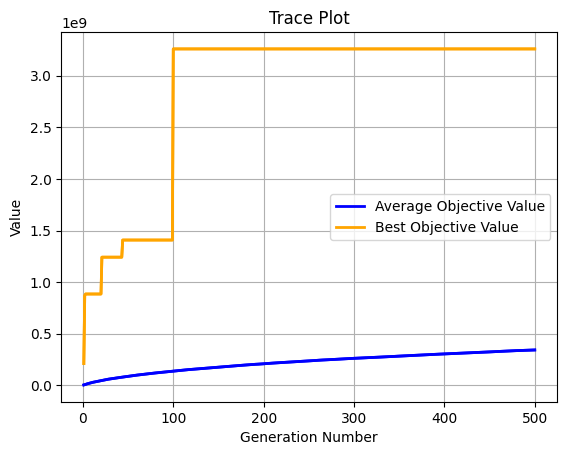

Execution time: 491.5240385532379 s
Evaluation number: 2500000
The best objective value is: 3259949226.393601
The best variables are: 
0	0	0	0	0	0	0	0	8	9	0	0	0	0	0	0	0	10	13	12	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	10	0	0	0	0	0	0	0	0	0	0	0	12	0	0	0	0	0	0	0	0	12	0	0	0	0	0	0	0	0	0	6	0	0	0	0	0	0	0	0	0	0	8	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	


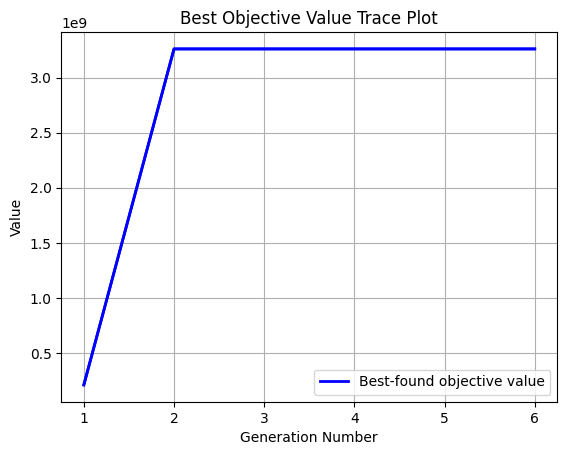

{'success': True, 'stopMsg': 'The algotirhm stepped because it exceeded the generation limit.', 'optPop': <geatpy.Population.Population object at 0x0000020A94B305B0>, 'lastPop': <geatpy.Population.Population object at 0x0000020A96807AF0>, 'Vars': array([[ 0,  0,  0,  0,  0,  0,  0,  0,  8,  9,  0,  0,  0,  0,  0,  0,
         0, 10, 13, 12,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0, 12,  0,  0,  0,  0,  0,  0,  0,  0, 12,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  8,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0]]), 'ObjV': array([[3.25994923e+09]]), 'CV': array([[0., 0.]]), 'executeTime': 491.5240385532379, 'nfev': 2500000, 'startTime': '2024-01-24 13h-27m-17s', 'endTime': '2024-01-24 13h-35m-29s'}


In [114]:
if __name__ == "__main__":
    problem = MyProblem()
    
    algorithm = ea.soea_SEGA_templet(
        problem,
        ea.Population(Encoding='RI', NIND=POP_SIZE),
        MAXGEN=GEN_NUM,
        logTras=100
    )
    
    algorithm.mutOper.F = 0.7
    algorithm.recOper.XOVR = 0.7
    
    res = ea.optimize(
        algorithm,
        verbose=True,
        drawing=1,
        outputMsg=True,
        drawLog=True
    )
    
    print(res)